1. Configuração Inicial

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from tensorflow.keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from keras import backend as K
from keras.losses import binary_crossentropy


2. Carregamento e Visualização dos Dados

C:\Users\USER\solar\lib\site-packages\rasterio\__init__.py:331: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


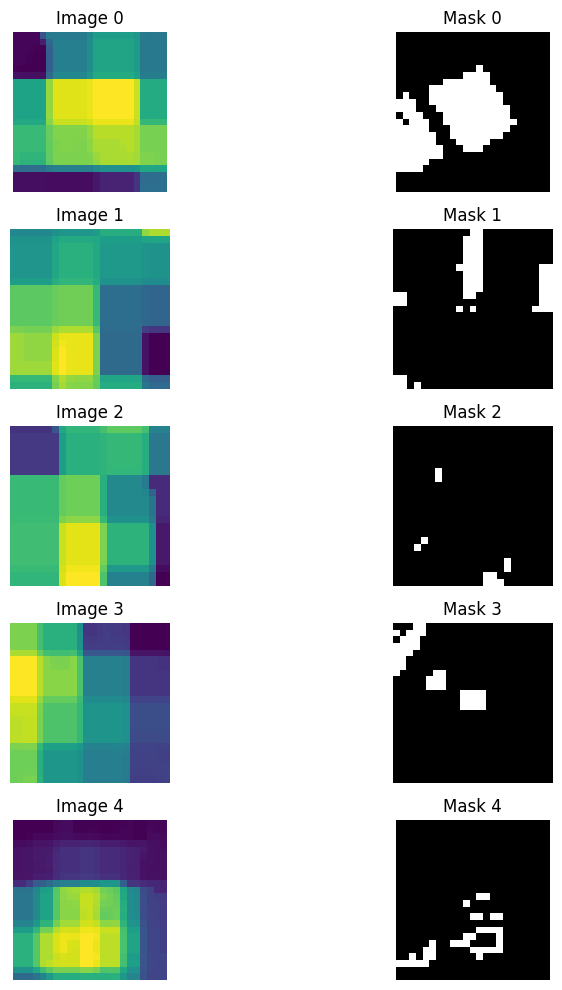

In [2]:
def load_image_rasterio(image_path):
    try:
        with rasterio.open(image_path) as src:
            return src.read()
    except IOError:
        return None

def load_image_pillow(image_path):
    try:
        with Image.open(image_path) as img:
            return np.array(img)
    except IOError:
        return None

# Definindo os caminhos das pastas onde as imagens e máscaras estão armazenadas
image_folder = '../solarpanel/data/external/train/s2_image'
mask_folder = '../solarpanel/data/external/train/mask'

# Número total de imagens e máscaras
num_images = 2066  # Ajuste este número conforme necessário

# Listas para armazenar as imagens e máscaras carregadas
images = []
masks = []

# Carregando todas as imagens e máscaras
for i in range(num_images):
    image_path = os.path.join(image_folder, f'train_s2_image_{i}.tif')
    mask_path = os.path.join(mask_folder, f'train_mask_{i}.tif')

    image = load_image_rasterio(image_path)
    mask = load_image_pillow(mask_path)

    if image is not None and mask is not None:
        images.append(image)
        masks.append(mask)
    else:
        print(f"Erro ao carregar a imagem ou a máscara: {i}")


# Número de amostras a serem visualizadas
num_samples = 5

# Ajuste o tamanho da figura conforme necessário
plt.figure(figsize=(10, 2 * num_samples))

for i in range(num_samples):
    image_to_show = images[i]
    mask_to_show = masks[i]

    # Ajuste para múltiplas bandas, se necessário
    if image_to_show.shape[0] > 3:
        image_to_show = image_to_show[0]
    image_to_show = np.moveaxis(image_to_show, 0, -1) if image_to_show.shape[0] < image_to_show.shape[1] else image_to_show

    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(image_to_show)
    plt.title(f'Image {i}')
    plt.axis('off')

    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(mask_to_show, cmap='gray')
    plt.title(f'Mask {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

3. Pré-processamento

In [4]:
def preprocess_image(image, target_size):
    # Se a imagem tem múltiplas bandas, ajuste conforme necessário
    if image.shape[0] > 3:
        # Exemplo: usando apenas a primeira banda
        image = image[0]

    # Reordenar as dimensões se necessário
    image = np.moveaxis(image, 0, -1) if image.shape[0] < image.shape[1] else image

    # Redimensionamento e normalização
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return image

def preprocess_mask(mask, target_size):
    # Redimensionamento e expansão da dimensão
    mask = cv2.resize(mask, target_size)
    mask = np.expand_dims(mask, axis=-1)
    return mask

# Exemplo de uso
processed_image = preprocess_image(image, (64, 64))
processed_mask = preprocess_mask(mask, (64, 64))

4. Construção do Modelo

In [5]:
# Definição da U-Net
def unet_model(input_size=(64, 64, 3)):
    inputs = Input(input_size)

    # Camada 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Camada 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Camada 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Camada 4 - Ponte
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.5)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Upsampling 1
    up1 = UpSampling2D(size=(2, 2))(conv4)
    merge1 = concatenate([conv3, up1], axis=3)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge1)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    # Upsampling 2
    up2 = UpSampling2D(size=(2, 2))(conv5)
    merge2 = concatenate([conv2, up2], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge2)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    # Upsampling 3
    up3 = UpSampling2D(size=(2, 2))(conv6)
    merge3 = concatenate([conv1, up3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge3)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    # Saída do modelo
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Funções de perda
def dice_loss(y_true, y_pred):
    numerator = 2 * K.sum(y_true * y_pred) + K.epsilon()
    denominator = K.sum(y_true + y_pred) + K.epsilon()
    return 1 - numerator / denominator

def combined_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


# Instanciar o modelo
model = unet_model()

model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy', MeanIoU(num_classes=2)])



5. Treinamento e Validação

In [26]:
# Funções de pré-processamento
def standardize_image(image, target_size=(64, 64), num_channels=3):
    image_resized = cv2.resize(image, target_size)
    if image_resized.ndim == 2:
        image_resized = np.expand_dims(image_resized, axis=-1)
    if image_resized.shape[-1] != num_channels:
        if image_resized.shape[-1] > num_channels:
            image_resized = image_resized[..., :num_channels]
        else:
            padding = [(0, 0) for _ in range(image_resized.ndim)]
            padding[-1] = (0, num_channels - image_resized.shape[-1])
            image_resized = np.pad(image_resized, padding, mode='constant', constant_values=0)
    return image_resized.astype(np.float32) / 255.0

def standardize_mask(mask, target_size=(64, 64)):
    mask_resized = cv2.resize(mask, target_size)
    if mask_resized.ndim == 2:
        mask_resized = np.expand_dims(mask_resized, axis=-1)
    return mask_resized.astype(np.float32) / 255.0


# Aplicando o pré-processamento
standardized_images = [standardize_image(img) for img in images]
standardized_masks = [standardize_mask(mask) for mask in masks]

# Diagnosticar quaisquer problemas
for i, img in enumerate(standardized_images):
    if img.shape != (64, 64, 3):
        print(f"Inconsistência encontrada na imagem {i}, forma: {img.shape}")
for i, mask in enumerate(standardized_masks):
    if mask.shape != (64, 64, 1):
        print(f"Inconsistência encontrada na máscara {i}, forma: {mask.shape}")

# Convertendo para arrays NumPy
images_array = np.array(standardized_images, dtype=np.float32) / 255.0
masks_array = np.array(standardized_masks, dtype=np.float32) / 255.0

# Divisão dos dados em conjuntos de treino e validação
X_train, X_val, y_train, y_val = train_test_split(images_array, masks_array, test_size=0.1, random_state=42)

# Treinamento do modelo
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=10)

Epoch 1/10
59/59 [==============================] - 839s 14s/step - loss: 1.5658 - accuracy: 0.8204 - mean_io_u_5: 1.0000 - val_loss: 1.2593 - val_accuracy: 0.9150 - val_mean_io_u_5: 1.0000
Epoch 2/10
59/59 [==============================] - 829s 14s/step - loss: 1.2825 - accuracy: 0.9119 - mean_io_u_5: 1.0000 - val_loss: 1.1564 - val_accuracy: 0.9150 - val_mean_io_u_5: 1.0000
Epoch 3/10
59/59 [==============================] - 817s 14s/step - loss: 1.1158 - accuracy: 0.9119 - mean_io_u_5: 1.0000 - val_loss: 1.0692 - val_accuracy: 0.9150 - val_mean_io_u_5: 1.0000
Epoch 4/10
59/59 [==============================] - 797s 14s/step - loss: 1.0520 - accuracy: 0.9119 - mean_io_u_5: 1.0000 - val_loss: 1.0363 - val_accuracy: 0.9150 - val_mean_io_u_5: 1.0000
Epoch 5/10
59/59 [==============================] - 826s 14s/step - loss: 1.0283 - accuracy: 0.9119 - mean_io_u_5: 1.0000 - val_loss: 1.0211 - val_accuracy: 0.9150 - val_mean_io_u_5: 1.0000
Epoch 6/10
59/59 [==============================] 

6. Avaliação do Modelo

In [33]:
# Função para calcular IoU
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# Gerar previsões
predictions = model.predict(X_val)

# Binarizar previsões e valores reais
predictions_binarized = (predictions > 0.5).astype(np.float32)
y_val_binarized = (y_val > 0.5).astype(np.float32)

# Achatamento dos arrays para cálculo das métricas
y_val_flat = y_val_binarized.flatten()
predictions_flat = predictions_binarized.flatten()

# Cálculo das métricas
precision = precision_score(y_val_flat, predictions_flat)
recall = recall_score(y_val_flat, predictions_flat)
iou = calculate_iou(y_val_flat, predictions_flat)

# Exibindo as métricas
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"IoU: {iou}")


7/7 [==============================] - 22s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0
IoU: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-33-ad1517f2738f>:5: RuntimeWarning: invalid value encountered in long_scalars
  iou_score = np.sum(intersection) / np.sum(union)


In [31]:
# Gere previsões com o modelo
predictions = model.predict(X_val)

# Binarizando as previsões
predictions_binarized = (predictions > 0.5).astype(np.float32)

# Binarizando os valores reais, se necessário
y_val_binarized = (y_val > 0.5).astype(np.float32)

# Achatamento dos arrays
y_val_flat = y_val_binarized.flatten()
predictions_flat = predictions_binarized.flatten()

# Calculando o F1-Score
f1 = f1_score(y_val_flat, predictions_flat)
print(f"F1-Score: {f1}")


7/7 [==============================] - 26s 3s/step
F1-Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
